Nr of atoms in the system: 2661
tensor([[[-1.0875, -0.1321, -0.1239],
         [-1.0975, -0.0572, -0.0652],
         [-1.0330, -0.1938, -0.0751],
         ...,
         [-0.1882,  1.4251,  0.3104],
         [-0.1575,  1.3662,  0.2415],
         [-0.2651,  1.4679,  0.2728]]], device='cuda:0', requires_grad=True)
Energy: -177909168.0 kJ/mol
Force: [[ 132.48724    20.660324  -23.68677 ]
 [-209.01137   138.32785  -132.82915 ]
 [-199.94128  -213.27568   231.62102 ]
 ...
 [ -89.983444   62.77565    93.666985]
 [-316.12738  -205.93634  -441.30447 ]
 [ 108.750046  -91.96801    93.74915 ]] 
time: 0.1266169548034668


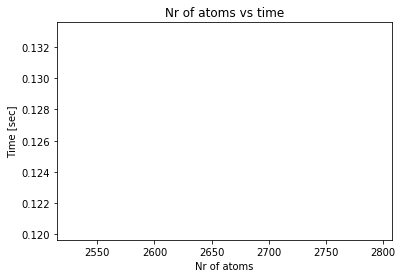

In [3]:
from openmmtools.testsystems import DHFRExplicit
from openmmtools.testsystems import WaterBox
import matplotlib.pyplot as plt

from simtk import unit
import numpy as np
import torchani
import torch
import time
from simtk import unit
import sys

# openmm units
mass_unit = unit.dalton
distance_unit = unit.nanometer
time_unit = unit.femtosecond
energy_unit = unit.kilojoule_per_mole
speed_unit = distance_unit / time_unit
force_unit = unit.kilojoule_per_mole / unit.nanometer

# ANI-1 units and conversion factors
ani_distance_unit = unit.angstrom
hartree_to_kJ_mol = 2625.499638
ani_energy_unit = hartree_to_kJ_mol * unit.kilojoule_per_mole # simtk.unit doesn't have hartree?
nm_to_angstroms = (1.0 * distance_unit) / (1.0 * ani_distance_unit)

nr_of_atoms = []
times = []
platform = 'cuda'

# testing different edge length
species = None
coordinates = None
device = None
model = None
n = 30

torchani.nn.torch.cuda.empty_cache()

device = torch.device(platform)
model = torchani.models.ANI1ccx()
model = model.to(device)

testsystem = WaterBox(box_edge=n*unit.angstrom)
x = testsystem.positions
top = testsystem.topology
dhfr_elements = [atom.element.symbol for atom in testsystem.topology.atoms()]
print('Nr of atoms in the system: {}'.format(len(dhfr_elements)))
element_string = ''.join(dhfr_elements)
element_string= element_string.replace('S', 'C')
species = model.species_to_tensor(element_string).to(device).unsqueeze(0)

coordinates = torch.tensor([x.value_in_unit(unit.nanometer)],
                        requires_grad=True, device=device, dtype=torch.float32)
print(coordinates)

t0 = time.time()
_, energy_in_hartree = model((species, coordinates * nm_to_angstroms))
energy_in_kJ_mol = energy_in_hartree * hartree_to_kJ_mol
print('Energy: {} kJ/mol'.format(energy_in_kJ_mol[0]))
derivative = torch.autograd.grad((energy_in_kJ_mol).sum(), coordinates)[0]
F = - np.array(derivative.cpu())[0] 
print('Force: {} '.format(F))

t1 = time.time()
t = t1-t0
print('time: {}'.format(t))
nr_of_atoms.append(len(dhfr_elements))
times.append(t)

plt.plot(nr_of_atoms, times)
plt.title('Nr of atoms vs time')
plt.xlabel('Nr of atoms')
plt.ylabel('Time [sec]')
plt.show()

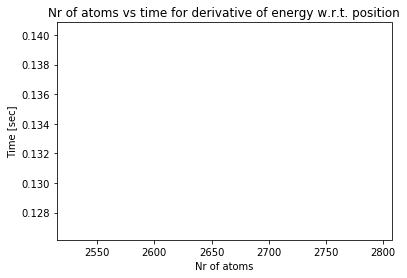

In [2]:
plt.plot(nr_of_atoms, times)
plt.title('Nr of atoms vs time for derivative of energy w.r.t. position')
plt.xlabel('Nr of atoms')
plt.ylabel('Time [sec]')
plt.show()